In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

'[' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', 'abd1a0daaa244313b6105aabaecb6cb0')

In [4]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [5]:
results = search_images_bing(key, 'quavo')
ims = results.attrgot('contentUrl')
len(ims)

149

In [6]:
dest = 'migos/quavo.jpg'
download_url(ims[0], dest)

Path('migos/quavo.jpg')

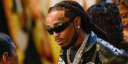

In [7]:
im = Image.open(dest)
im.to_thumb(128,128)

In [8]:
migos = 'quavo','takeoff','offset'
path = Path('migos')

In [9]:
if not path.exists():
    path.mkdir()
    for o in migos:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [10]:
fns = get_image_files(path)
fns

(#394) [Path('migos/quavo.jpg'),Path('migos/offset/01af2b2d-f7d7-42f7-8f99-cf8423141e89.jpg'),Path('migos/offset/02dac23a-94b5-45a1-9e8b-6ff2e6ce32f5.jpg'),Path('migos/offset/045d6846-919e-45ac-8e5f-1a4fdabfb03c.jpg'),Path('migos/offset/06ea732e-2c94-4e8c-9086-d6f6f3341dcb.jpg'),Path('migos/offset/07e65a4e-ed39-4b72-b859-7d022f2d766f.jpg'),Path('migos/offset/0c5570f4-5c7b-4dc1-a62e-3b0fdd412797.jpg'),Path('migos/offset/0ce69103-6beb-4a81-ab3d-a3cb9f55bd8f.png'),Path('migos/offset/12901969-6db2-4567-a38b-f051eee75f26.jpg'),Path('migos/offset/14da833d-752c-4753-9ccd-de6f014c33fd.jpg'),Path('migos/offset/1508a2d5-ed08-4f42-b230-95b2e1297d4d.jpg'),Path('migos/offset/166e24e3-4287-412e-b002-b90c205b2f18.jpg'),Path('migos/offset/1702da37-89f0-40f9-ab19-2e2ed84941a5.jpg'),Path('migos/offset/19cf4db5-d756-4df3-a6df-431e39f9b4f8.jpg'),Path('migos/offset/1c9268c8-5822-4a22-956f-64cf00ef391e.jpg'),Path('migos/offset/1d5ed076-20cc-4f12-a7ed-e59bfd6b5dd2.jpg'),Path('migos/offset/1edb39cc-941d-4111-

In [11]:
failed = verify_images(fns)
failed

(#0) []

In [12]:
failed.map(Path.unlink)

(#0) []

In [13]:
migos = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [14]:
dls = migos.dataloaders(path)

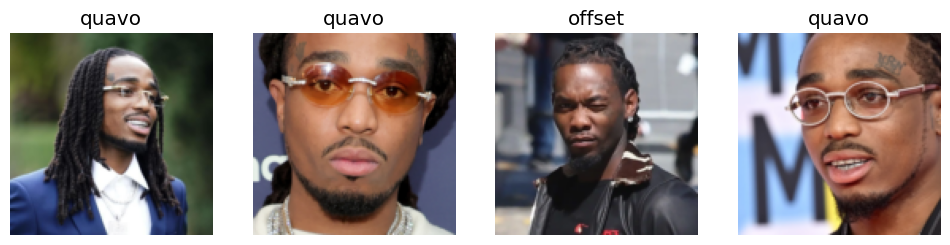

In [15]:
dls.valid.show_batch(max_n=4, nrows=1)

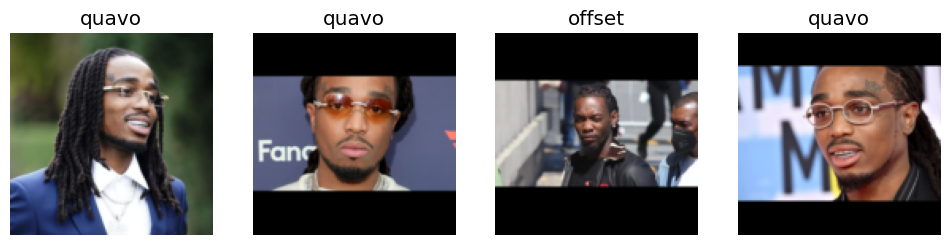

In [16]:
migos = migos.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = migos.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

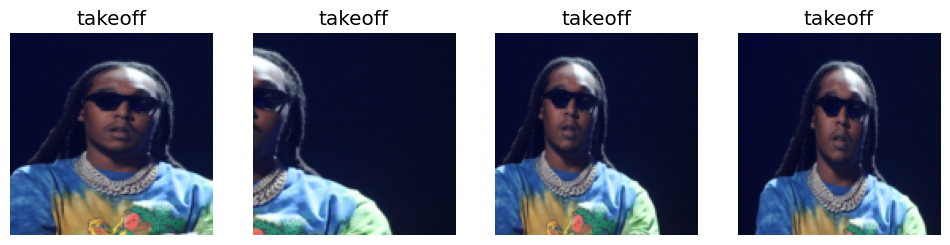

In [17]:
migos = migos.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = migos.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

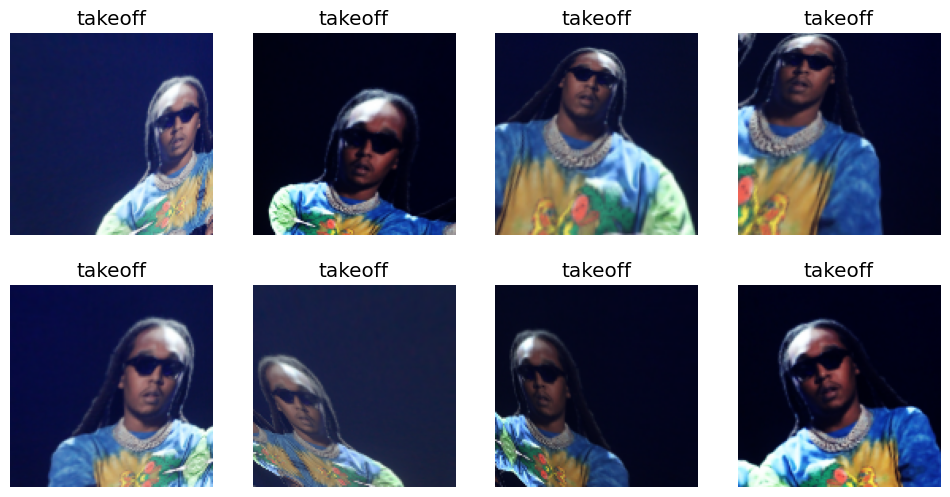

In [18]:
migos = migos.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = migos.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [19]:
migos = migos.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = migos.dataloaders(path)

In [20]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.244601,3.015354,0.897436,01:07


epoch,train_loss,valid_loss,error_rate,time
0,1.836474,1.952099,0.717949,01:16
1,1.644381,1.573765,0.512821,02:37
2,1.493002,1.399160,0.410256,01:17
3,1.355327,1.352216,0.461538,01:16


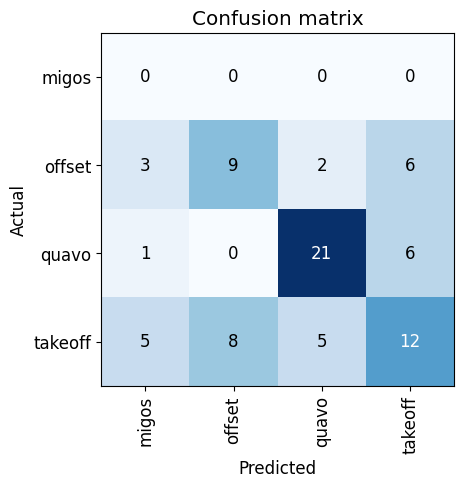

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

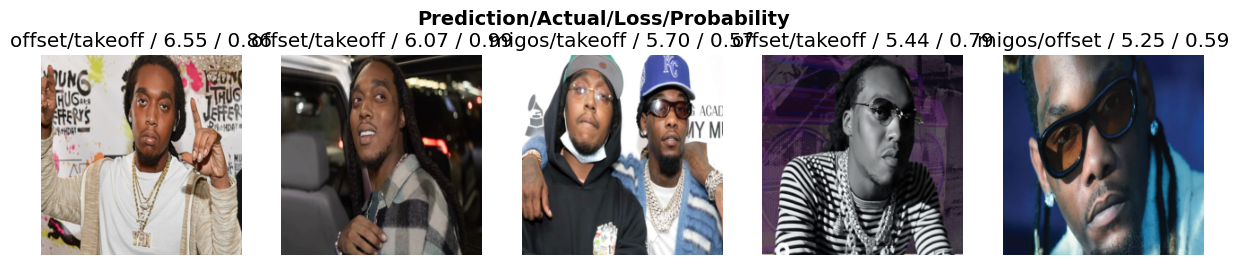

In [22]:
interp.plot_top_losses(5, nrows=1)

In [32]:
cleaner = ImageClassifierCleaner(learn)
cleaner

FileNotFoundError: [Errno 2] No such file or directory: 'migos\\quavo\\ced77a11-6d41-4ba9-bd1d-75e5c5f6d28a.jpg'

In [31]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [33]:
learn.export()

In [34]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [35]:
learn_inf = load_learner(path/'export.pkl')

In [36]:
learn_inf.dls.vocab

['migos', 'offset', 'quavo', 'takeoff']

In [29]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [37]:
img = PILImage.create(btn_upload.data[-1])

In [38]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [39]:
pred,pred_idx,probs = learn_inf.predict(img)

In [40]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: offset; Probability: 0.7868')

In [41]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [42]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [43]:
btn_upload = widgets.FileUpload()

In [44]:
VBox([widgets.Label('Select your rapper!'), 
      btn_upload, btn_run, out_pl, lbl_pred])